# Forecasting Asset Pair Prices with Boosting Models

This notebook explores forecasting of asset pair targets using **gradient boosting models**.  
The dataset consists of **targets**, where each target corresponds to either a single instrument or a pair of instruments (long and short).  

## Plan
1. **Feature Engineering**  
   - Lag returns, SMA, EMA, rolling volatility, RSI, and day-of-week (cyclical features).  
   - For pairs, create *difference features* between long and short legs.  

2. **Modeling**  
   - Compare **LightGBM** vs **XGBoost** on different feature sets.  
   - Use **RMSE** as the evaluation metric.  
   - Apply **Optuna tuning** (bayesian optimization) for XGBoost.  

3. **Results Summary**  
   - Only **lag features** are necessary to achieve the best performance.  
   - **XGBoost consistently outperforms LightGBM** across feature sets.  
   - Adding SMA, EMA, VOL, RSI, or DOW features does not significantly improve results.  

---

## Model Performance (Fold RMSE)

### 1. Only Lag Features
| Fold | LGB RMSE | XGB RMSE |
|------|----------|----------|
| 1    | 0.03646  | 0.03584  |
| 2    | 0.03191  | 0.03089  |
| 3    | 0.02626  | 0.02501  |

### 2. Lag + RSI
| Fold | LGB RMSE | XGB RMSE |
|------|----------|----------|
| 1    | 0.03644  | 0.03583  |
| 2    | 0.03197  | 0.03091  |
| 3    | 0.02639  | 0.02510  |

(Additional tables omitted here — see code below for details.)

---

## Observations
- **Lag features dominate** — they capture most of the signal.  
- **XGBoost > LightGBM** in all experiments (with default parameters).  
- Other features (RSI, SMA, EMA, VOL, DOW) add little to no improvement.  
- Future work could include **cross-sectional ranking** or **windsorizing extreme values**.  


In [1]:
import pandas as pd
from pathlib import Path
from typing import Dict, List
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import optuna

# TODO: Try windsorizing the data for beter results in future to eliminate the extereme cases
# TODO: Add cross-sectional ranking within an asset class to give the model some insight about asset rankings.

# Load data
DATA_DIR = Path('.')

pairs = pd.read_csv(DATA_DIR/'target_pairs.csv')
raw = pd.read_csv(DATA_DIR/'train.csv')
labels = pd.read_csv(DATA_DIR/'train_labels.csv')

pairs['target_id'] = pairs['target'].str.split('_').str[1].astype(int)
pairs['legs'] = pairs['pair'].str.split(' - ')
pairs['type'] = pairs['legs'].apply(lambda x: 'pair' if len(x) == 2 else 'single').astype(str)

target_instruments = list(set([leg for legs in pairs['legs'] for leg in legs]))

# Price series of target instruments
prices = pd.melt(raw, id_vars="date_id", value_vars=target_instruments)
prices.rename(columns={"variable": "instrument", "value": "price"}, inplace=True)
prices = prices.sort_values(["date_id", "instrument"]).reset_index(drop=True)


# Feature engineering part. I defined various features but not all of them are used.
LAGS = [1, 2, 3]
SMA_WINDOWS = [3, 5, 10, 20]
EMA_WINDOWS = [3, 5, 10, 20]
VOL_WINDOWS = [3, 5, 10, 20]
RSI_WINDOW = 14

def compute_per_instrument_features(prices: pd.DataFrame) -> pd.DataFrame:

    df = prices.copy()

    df["log_price"] = np.log(df["price"])
    df["ret_1"] = df.groupby("instrument")["log_price"].diff(1)

    # Lag feature 
    for lag in LAGS:
        df[f"lag_{lag}"] = df.groupby("instrument")["ret_1"].shift(lag)

    # Simple moving average to capture trends
    for window in SMA_WINDOWS:
        df[f"SMA_{window}"] = df.groupby("instrument")["ret_1"].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=window).mean())

    # Exponential moving averege to capture decaying impact
    for window in EMA_WINDOWS:
        df[f"EMA_{window}"] = df.groupby("instrument")["ret_1"].transform(
            lambda x: x.shift(1).ewm(span=window, min_periods=window).mean())

    # Rolling volatility to capture risk
    for window in VOL_WINDOWS:
        df[f"VOL_{window}"] = df.groupby("instrument")["ret_1"].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=window).std())

    # Relative Strength Index (RSI)
    # Over 70 hints that the stock is overbought, and below 30 means oversold.
    df["up"] = df["ret_1"].clip(lower=0)
    df["down"] = -df["ret_1"].clip(upper=0)
    df["avg_gain"] = df.groupby("instrument")["up"].transform(
        lambda x: x.shift(1).rolling(RSI_WINDOW).mean())
    df["avg_loss"] = df.groupby("instrument")["down"].transform(
        lambda x: x.shift(1).rolling(RSI_WINDOW).mean()).replace(0, np.nan)
    df["RS"] = df["avg_gain"] / df["avg_loss"]
    df["RSI"] = 100 - (100 / (1 + df["RS"]))

    # Cyclic day encoding via one-hot
    df["DOW"] = df["date_id"] % 5
    df = pd.get_dummies(df, columns=["DOW"], prefix="DOW", dtype=int)

    return df

base_features = compute_per_instrument_features(prices)

# Define feature store for fast lookup
keep_cols = ["date_id", "instrument", "price", "log_price", "ret_1"]
keep_cols += [f"lag_{lag}" for lag in LAGS]
keep_cols += [f"SMA_{window}" for window in SMA_WINDOWS]
keep_cols += [f"EMA_{window}" for window in EMA_WINDOWS]
keep_cols += [f"VOL_{window}" for window in VOL_WINDOWS]
keep_cols += ["RSI"]
keep_cols += [f"DOW_{date}" for date in [0, 1, 2, 3, 4]]

feature_store = base_features[keep_cols].copy()
feature_store.set_index(["date_id", "instrument"], inplace=True)
feature_store.sort_index(inplace=True)

# Convert to long format for easier manipulation
for col in labels.columns:
    if col.startswith("target"):
        n = col.split("_")[1]
        labels.rename(columns={f"{col}": f"{n}"}, inplace=True)

# Melt into long format
labels_long = (
    labels.melt(id_vars="date_id")
    .rename(columns={"date_id": "label_date_id", "variable": "target_id", "value": "price"})
)
labels_long = labels_long.astype({"target_id": int})

# Attach pair_type + legs
legs_map: Dict[int, List[str]] = dict(zip(pairs['target_id'], pairs['legs']))
pair_type_map: Dict[int, str] = dict(zip(pairs['target_id'], pairs['type']))

labels_long["pair_type"] = labels_long["target_id"].map(pair_type_map)
labels_long["legs"] = labels_long["target_id"].map(legs_map)

# Effective date gives the first date that features are taken from
MAX_LOOKBACK_WINDOW = max(max(LAGS), max(SMA_WINDOWS), max(EMA_WINDOWS), max(VOL_WINDOWS), RSI_WINDOW)
labels_long["eff_date_id"] = labels_long["label_date_id"] - MAX_LOOKBACK_WINDOW


def get_leg_features(label_date_id: int, instrument: str, prefix: str):
    try:
        row = feature_store.loc[(int(label_date_id), instrument)]
    except KeyError:
        return None
    return {f"{prefix}{k}": v for k, v in row.items()}

# Build training matrix
rows = []
diff = [ins for ins in keep_cols if not ins in ["date_id", "instrument", "DOW_0", "DOW_1", "DOW_2", "DOW_3", "DOW_4"]]

for i, label_row in labels_long.iterrows():
    label_date_id = int(label_row["label_date_id"])
    target_id = int(label_row["target_id"])
    y = float(label_row["price"])
    pair_type = label_row["pair_type"]
    eff_date_id = int(label_row["eff_date_id"])
    legs = label_row["legs"]

    base = {
        "label_date_id": label_date_id,
        "target_id": target_id,
        "y": y,
        "eff_date_id": eff_date_id,
        "pair_type_single": 1 if pair_type == "single" else 0,
        "pair_type_pair": 1 if pair_type == "pair" else 0,
    }

    if pair_type == "single":
        leg = legs[0]
        A_features = get_leg_features(label_date_id, leg, prefix="A_")
        if A_features is None:
            continue   
        row = {**base, **A_features}
    else:
        A, B = legs
        A_features = get_leg_features(label_date_id, A, prefix="A_")
        B_features = get_leg_features(label_date_id, B, prefix="B_")
        if (A_features is None) or (B_features is None):
            continue
        row = {**base, **A_features, **B_features}
        for feature in diff:
            a_key = f"A_{feature}"
            b_key = f"B_{feature}"
            row[f"diff_{feature}"] = row[a_key] - row[b_key]

    rows.append(row)

train_matrix = pd.DataFrame(rows)

# Clean the data before the lookback window
train_matrix = train_matrix[train_matrix["eff_date_id"] >= 0].copy()

train_matrix

/home/emre/miniconda3/envs/py3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,label_date_id,target_id,y,eff_date_id,pair_type_single,pair_type_pair,A_price,A_log_price,A_ret_1,A_lag_1,...,diff_SMA_20,diff_EMA_3,diff_EMA_5,diff_EMA_10,diff_EMA_20,diff_VOL_3,diff_VOL_5,diff_VOL_10,diff_VOL_20,diff_RSI
20,20,0,-0.000766,0,1,0,66.7859,4.201492,-0.010296,-0.008313,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,21,0,-0.022090,1,1,0,66.8456,4.202385,0.000894,-0.010296,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,22,0,-0.039157,2,1,0,66.7944,4.201619,-0.000766,0.000894,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,23,0,0.020702,3,1,0,65.3351,4.179529,-0.022090,-0.000766,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,24,0,-0.012854,4,1,0,62.8262,4.140372,-0.039157,-0.022090,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812803,1912,423,NaN,1892,0,1,9523.5000,9.161518,0.008012,-0.013614,...,NaN,-0.000439,-0.002520,-0.006464,-0.008650,-0.021645,-0.013553,-0.011106,NaN,-26.209124
812804,1913,423,-0.141053,1893,0,1,9519.5000,9.161098,-0.000420,0.008012,...,NaN,0.004665,0.001578,-0.003483,-0.006833,-0.005859,-0.013275,-0.011235,NaN,-20.448471
812805,1914,423,-0.127688,1894,0,1,9533.5000,9.162567,0.001470,-0.000420,...,NaN,-0.009656,-0.006942,-0.007232,-0.008509,-0.005160,-0.016111,-0.013133,NaN,-24.797488
812806,1915,423,-0.012187,1895,0,1,9500.5000,9.159100,-0.003467,0.001470,...,-0.012187,-0.001894,-0.002671,-0.004838,-0.007107,-0.011010,-0.012021,-0.012930,-0.008912,-7.114861


In [2]:
CV_SPLITS = 3
tscv = TimeSeriesSplit(n_splits=CV_SPLITS)

# For beginners use only lag features
#df = train_matrix.drop(columns=train_matrix.filter(regex="VOL|EMA|RSI|SMA").columns).copy()
df = train_matrix.drop(columns=train_matrix.filter(regex="EMA|SMA|VOL|DOW|RSI").columns).copy()
df = train_matrix.copy()
df = df.replace([np.inf, -np.inf], np.nan)
df = df[df["y"].notna()]

exclude_cols = ["label_date_id", "target_id", "y", "eff_date_id", "pair_type_single", "pair_type_pair", 
                "A_price", "A_log_price", "B_price", "B_log_price", "diff_price", "diff_log_price"]

feature_cols = [col for col in df.columns if col not in exclude_cols]

targets = df["target_id"].unique()

fold_rmse_lgb = [ [] for _ in range(CV_SPLITS) ]
fold_rmse_xgb = [ [] for _ in range(CV_SPLITS) ]

for target_id in targets:

	#print(f"Target {target_id}")

	df_target = df[df["target_id"] == target_id].copy()

	X = df_target[feature_cols].apply(pd.to_numeric, errors="coerce")  # Just in case
	y = df_target["y"].values

	for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
		X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
		y_train, y_val = y[train_idx], y[val_idx]

		# LigthGBM
		LGB_model = lgb.LGBMRegressor(
			n_estimators=80,
			learning_rate=0.05,
			max_depth=-1,
			num_leaves=64,
			subsample=0.8,
			colsample_bytree=0.8,
			random_state=42,
			verbose=-1
        )
		LGB_model.fit(X_train, y_train)
		LGB_preds = LGB_model.predict(X_val)
		LGB_rmse = np.sqrt(mean_squared_error(y_val, LGB_preds))
		fold_rmse_lgb[fold].append(LGB_rmse)

		# XGboost
		dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(X.columns))
		dval = xgb.DMatrix(X_val, label=y_val, feature_names=list(X.columns))
		params = {
			"objective": "reg:squarederror",
			"eval_metric": "rmse",
			"eta": 0.05,
			"max_depth": 3,
			"subsample": 0.8,
			"colsample_bytree": 0.8,
			"seed": 42,
		}
    
		XGB_model = xgb.train(params, dtrain, num_boost_round=500, 
		evals=[(dval, "validation")],
		early_stopping_rounds=20,
		verbose_eval=False)

		XGB_preds = XGB_model.predict(dval)
		XGB_rmse = np.sqrt(mean_squared_error(y_val, XGB_preds))
		fold_rmse_xgb[fold].append(XGB_rmse)
		
		#print(f"Fold:{fold+1}, Target:{target_id}, LGB_RMSE:{LGB_rmse:.5f}, XGB_RMSE{XGB_rmse:.5f}")


# Compute average RMSE per fold across all targets
for fold in range(CV_SPLITS):
    avg_lgb = np.mean(fold_rmse_lgb[fold])
    avg_xgb = np.mean(fold_rmse_xgb[fold])
    print(f"\nFold {fold+1} Average RMSE -> LGB: {avg_lgb:.5f}, XGB: {avg_xgb:.5f}")


Fold 1 Average RMSE -> LGB: 0.03667, XGB: 0.03566

Fold 2 Average RMSE -> LGB: 0.03222, XGB: 0.03064

Fold 3 Average RMSE -> LGB: 0.02663, XGB: 0.02493


## Feature Experiments and Model Performance

Experimented with different feature sets to evaluate their impact on model performance. 
Models tested include **LightGBM (LGB)** and **XGBoost (XGB)**. The metric used is **RMSE**, averaged per fold across all targets.

### 1. Only Lag Features
| Fold | LGB RMSE | XGB RMSE |
|------|----------|----------|
| 1    | 0.03646  | 0.03584  |
| 2    | 0.03191  | 0.03089  |
| 3    | 0.02626  | 0.02501  |

### 2. Lag + RSI
| Fold | LGB RMSE | XGB RMSE |
|------|----------|----------|
| 1    | 0.03644  | 0.03583  |
| 2    | 0.03197  | 0.03091  |
| 3    | 0.02639  | 0.02510  |

### 3. Lag + Volatility (VOL)
| Fold | LGB RMSE | XGB RMSE |
|------|----------|----------|
| 1    | 0.03657  | 0.03594  |
| 2    | 0.03217  | 0.03095  |
| 3    | 0.02658  | 0.02518  |

### 4. Lag + EMA
| Fold | LGB RMSE | XGB RMSE |
|------|----------|----------|
| 1    | 0.03663  | 0.03600  |
| 2    | 0.03210  | 0.03096  |
| 3    | 0.02636  | 0.02512  |

### 5. Lag + SMA
| Fold | LGB RMSE | XGB RMSE |
|------|----------|----------|
| 1    | 0.03649  | 0.03586  |
| 2    | 0.03217  | 0.03097  |
| 3    | 0.02654  | 0.02518  |

### 6. Lag + Day of Week (DOW)
| Fold | LGB RMSE | XGB RMSE |
|------|----------|----------|
| 1    | 0.03644  | 0.03584  |
| 2    | 0.03189  | 0.03087  |
| 3    | 0.02622  | 0.02502  |

### 7. All Features
| Fold | LGB RMSE | XGB RMSE |
|------|----------|----------|
| 1    | 0.03667  | 0.03604  |
| 2    | 0.03222  | 0.03100  |
| 3    | 0.02663  | 0.02521  |

In [3]:

target_rmse = {}
pred_rows = []

optuna.logging.set_verbosity(optuna.logging.WARNING)

CV_SPLITS = 3
tscv = TimeSeriesSplit(n_splits=CV_SPLITS)

# Prepare dataset
df = train_matrix.drop(columns=train_matrix.filter(regex="VOL|EMA|RSI|SMA|DOW").columns).copy()
df = df.replace([np.inf, -np.inf], np.nan)
df = df[df["y"].notna()]

exclude_cols = ["label_date_id", "target_id", "y", "eff_date_id", "pair_type_single", "pair_type_pair", 
                "A_price", "A_log_price", "B_price", "B_log_price", "diff_price", "diff_log_price"]

feature_cols = [col for col in df.columns if col not in exclude_cols]
targets = df["target_id"].unique()

fold_rmse_xgb = [ [] for _ in range(CV_SPLITS) ]

def xgb_objective(trial, X_train, y_train, X_val, y_val):
    params = {
        "tree_method": "hist",
        "device": "cuda",  # use GPU
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "eta": trial.suggest_categorical("eta", [0.005, 0.01, 0.015]),
        "max_depth": trial.suggest_int("max_depth", 2, 5),
        "subsample": trial.suggest_categorical("subsample", [0.6, 0.7, 0.8, 0.9, 1.0]),
        "colsample_bytree": trial.suggest_categorical("colsample_bytree", [0.6, 0.7, 0.8, 0.9, 1.0]),
        "seed": 35,
        "verbosity": 0, 
    }

    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(X_train.columns))
    dval = xgb.DMatrix(X_val, label=y_val, feature_names=list(X_val.columns))

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=500,
        evals=[(dval, "validation")],
        early_stopping_rounds=20,
        verbose_eval=False
    )

    preds = model.predict(dval)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse

for target_id in targets:
    print(f"target {target_id}")
    df_target = df[df["target_id"] == target_id].copy()
    X = df_target[feature_cols].apply(pd.to_numeric, errors="coerce")
    y = df_target["y"].values

    rmses = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Optuna search
        study = optuna.create_study(direction="minimize")
        study.optimize(lambda trial: xgb_objective(trial, X_train, y_train, X_val, y_val),
                       n_trials=10, show_progress_bar=False)

        best_params = study.best_params

        # Train final XGB with best params
        dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(X_train.columns))
        dval = xgb.DMatrix(X_val, label=y_val, feature_names=list(X_val.columns))

        final_model = xgb.train(
            best_params,
            dtrain,
            num_boost_round=500,
            evals=[(dval, "validation")],
            early_stopping_rounds=20,
            verbose_eval=False
        )

        preds = final_model.predict(dval)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        rmses.append(rmse)
        fold_rmse_xgb[fold].append(rmse)

        # Train_matrix shape
        fold_preds = pd.DataFrame({
            "label_date_id": df_target.iloc[val_idx]["label_date_id"].values,
            "target_id": target_id,
            "y": y_val,
            "y_pred": preds
        })
        pred_rows.append(fold_preds)

    target_rmse[target_id] = np.mean(rmses)

# Fold 
for fold in range(CV_SPLITS):
    avg_rmse = np.mean(fold_rmse_xgb[fold])
    print(f"Fold {fold+1} Average XGB RMSE: {avg_rmse:.5f}")


target 0
target 1
target 2
target 3
target 4
target 5
target 6
target 7
target 8
target 9
target 10
target 11
target 12
target 13
target 14
target 15
target 16
target 17
target 18
target 19
target 20
target 21
target 22
target 23
target 24
target 25
target 26
target 27
target 28
target 29
target 30
target 31
target 32
target 33
target 34
target 35
target 36
target 37
target 38
target 39
target 40
target 41
target 42
target 43
target 44
target 45
target 46
target 47
target 48
target 49
target 50
target 51
target 52
target 53
target 54
target 55
target 56
target 57
target 58
target 59
target 60
target 61
target 62
target 63
target 64
target 65
target 66
target 67
target 68
target 69
target 70
target 71
target 72
target 73
target 74
target 75
target 76
target 77
target 78
target 79
target 80
target 81
target 82
target 83
target 84
target 85
target 86
target 87
target 88
target 89
target 90
target 91
target 92
target 93
target 94
target 95
target 96
target 97
target 98
target 99
target 100

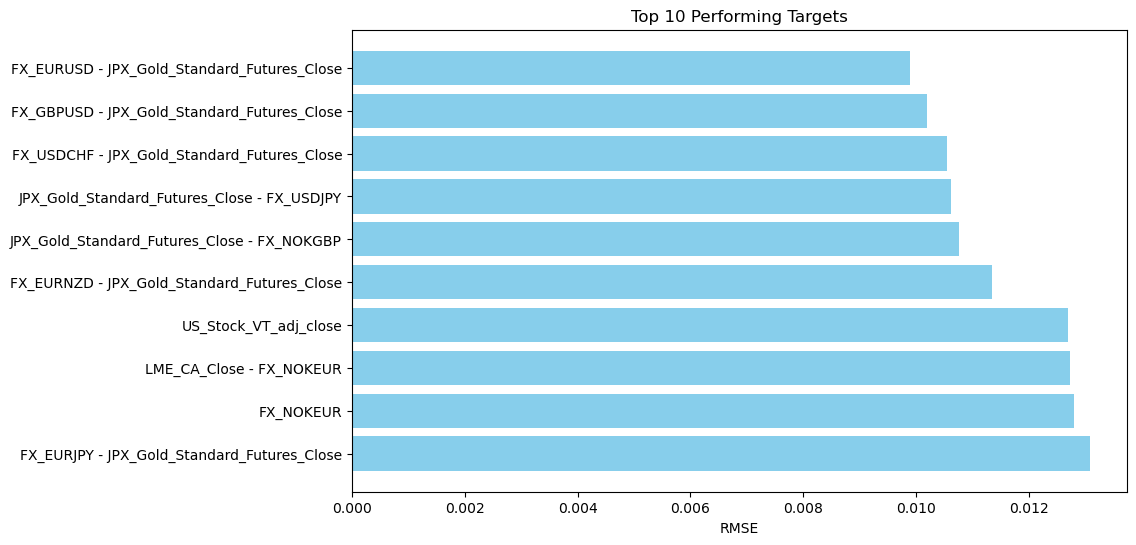

Target 68: FX_EURUSD - JPX_Gold_Standard_Futures_Close -> RMSE 0.00989
Target 81: FX_GBPUSD - JPX_Gold_Standard_Futures_Close -> RMSE 0.01020
Target 70: FX_USDCHF - JPX_Gold_Standard_Futures_Close -> RMSE 0.01055
Target 19: JPX_Gold_Standard_Futures_Close - FX_USDJPY -> RMSE 0.01061
Target 44: JPX_Gold_Standard_Futures_Close - FX_NOKGBP -> RMSE 0.01075
Target 71: FX_EURNZD - JPX_Gold_Standard_Futures_Close -> RMSE 0.01134
Target 0: US_Stock_VT_adj_close -> RMSE 0.01269
Target 45: LME_CA_Close - FX_NOKEUR -> RMSE 0.01272
Target 318: FX_NOKEUR -> RMSE 0.01279
Target 153: FX_EURJPY - JPX_Gold_Standard_Futures_Close -> RMSE 0.01308


In [9]:
pred_matrix = pd.concat(pred_rows, ignore_index=True)
pred_matrix.to_csv("train_predictions.csv", index=False)

sorted_targets = sorted(target_rmse.items(), key=lambda x: x[1])
top10 = sorted_targets[:10]

top10_ids, top10_scores = zip(*top10)
top10_names = [
    " - ".join(pairs.loc[pairs['target_id'] == tid, 'legs'].values[0])
    for tid in top10_ids
]

plt.figure(figsize=(10, 6))
plt.barh(top10_names, top10_scores, color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("RMSE")
plt.title("Top 10 Performing Targets")
plt.savefig("top10_targets.png", dpi=300, bbox_inches="tight")
plt.show()

for tid, name, score in zip(top10_ids, top10_names, top10_scores):
    print(f"Target {tid}: {name} -> RMSE {score:.5f}")